# CAPSTONE INVESTIGACIÓN OPERATIVA

In [93]:
#encender .venv
!.\.venv\Scripts\activate.bat

### Instalación de dependencias en el .venv

In [94]:
# Instala y actualiza los paquetes necesarios
%pip install --upgrade pip
%pip install numpy==2.2 pandas scikit-learn matplotlib joblib gurobipy gurobi-machinelearning pandas-datareader xgboost shap optuna

# Verifica la versión de scikit-learn y Python
import sklearn, sys
print("Python version:", sys.version)
print("scikit-learn version:", sklearn.__version__)

# Importa y verifica pandas_datareader
import importlib
import pandas_datareader as pdr
print("pandas_datareader OK:", importlib.metadata.version("pandas-datareader"))

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
scikit-learn version: 1.7.1
pandas_datareader OK: 0.10.0


### Importamos Librerias necesarias

In [95]:
# ============ Config & IO ============
import re
import time
#importamos numpy version 2.2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # muestra todas las columnas

# ============ Scikit-learn ============
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
# ===== IMPORTS extra =====
from sklearn.base import clone           # por si no lo tenías
from xgboost import XGBRegressor         # pip install xgboost


# ============ Gurobi / MIP ============
import gurobipy as gp
from gurobipy import GRB
from gurobi_ml import add_predictor_constr

# ============ Datos externos (opcional) ============
from pandas_datareader.data import DataReader  # si usas FRED/CPI
from sklearn.base import clone

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Prepocesamiento de la base de datos "AmesHousing"

In [96]:
FILE = "ames_dum.csv"
df = pd.read_csv(FILE)
df.head()


,Lot_Frontage,Lot_Area,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Sale_Price,Longitude,Latitude,Sale_Price_Log,MS_SubClass_One_Story_1945_and_Older,MS_SubClass_One_Story_with_Finished_Attic_All_Ages,MS_SubClass_One_and_Half_Story_Unfinished_All_Ages,MS_SubClass_One_and_Half_Story_Finished_All_Ages,MS_SubClass_Two_Story_1946_and_Newer,MS_SubClass_Two_Story_1945_and_Older,MS_SubClass_Two_and_Half_Story_All_Ages,MS_SubClass_Split_or_Multilevel,MS_SubClass_Split_Foyer,MS_SubClass_Duplex_All_Styles_and_Ages,MS_SubClass_One_Story_PUD_1946_and_Newer,MS_SubClass_One_and_Half_Story_PUD_All_Ages,MS_SubClass_Two_Story_PUD_1946_and_Newer,MS_SubClass_PUD_Multilevel_Split_Level_Foyer,MS_SubClass_Two_Family_conversion_All_Styles_and_Ages,MS_Zoning_Residential_High_Density,MS_Zoning_Residential_Low_Density,MS_Zoning_Residential_Medium_Density,MS_Zoning_A_agr,MS_Zoning_C_all,MS_Zoning_I_all,Lot_Shape_Slightly_Irregular,Lot_Shape_Moderately_Irregular,Lot_Shape_Irregular,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl,Lot_Config_CulDSac,Lot_Config_FR2,Lot_Config_FR3,Lot_Config_Inside,Neighborhood_College_Creek,Neighborhood_Old_Town,Neighborhood_Edwards,Neighborhood_Somerset,Neighborhood_Northridge_Heights,Neighborhood_Gilbert,Neighborhood_Sawyer,Neighborhood_Northwest_Ames,Neighborhood_Sawyer_West,Neighborhood_Mitchell,Neighborhood_Brookside,Neighborhood_Crawford,Neighborhood_Iowa_DOT_and_Rail_Road,Neighborhood_Timberland,Neighborhood_Northridge,Neighborhood_Stone_Brook,Neighborhood_South_and_West_of_Iowa_State_University,Neighborhood_Clear_Creek,Neighborhood_Meadow_Village,Neighborhood_Briardale,Neighborhood_Bloomington_Heights,Neighborhood_Veenker,Neighborhood_Northpark_Villa,Neighborhood_Blueste,Neighborhood_Greens,Neighborhood_Green_Hills,Neighborhood_Landmark,Neighborhood_Hayden_Lake,Condition_1_Feedr,Condition_1_Norm,Condition_1_PosA,Condition_1_PosN,Condition_1_RRAe,Condition_1_RRAn,Condition_1_RRNe,Condition_1_RRNn,Bldg_Type_TwoFmCon,Bldg_Type_Duplex,Bldg_Type_Twnhs,Bldg_Type_TwnhsE,House_Style_One_and_Half_Unf,House_Style_One_Story,House_Style_SFoyer,House_Style_SLvl,House_Style_Two_and_Half_Fin,House_Style_Two_and_Half_Unf,House_Style_Two_Story,Roof_Style_Gable,Roof_Style_Gambrel,Roof_Style_Hip,Roof_Style_Mansard,Roof_Style_Shed,Roof_Matl_CompShg,Roof_Matl_Membran,Roof_Matl_Metal,Roof_Matl_Roll,Roof_Matl_Tar&Grv,Roof_Matl_WdShake,Roof_Matl_WdShngl,Exterior_1st_AsphShn,Exterior_1st_BrkComm,Exterior_1st_BrkFace,Exterior_1st_CBlock,Exterior_1st_CemntBd,Exterior_1st_HdBoard,Exterior_1st_ImStucc,Exterior_1st_MetalSd,Exterior_1st_Plywood,Exterior_1st_PreCast,Exterior_1st_Stone,Exterior_1st_Stucco,Exterior_1st_VinylSd,Exterior_1st_Wd Sdng,Exterior_1st_WdShing,Exterior_2nd_AsphShn,Exterior_2nd_Brk Cmn,Exterior_2nd_BrkFace,Exterior_2nd_CBlock,Exterior_2nd_CmentBd,Exterior_2nd_HdBoard,Exterior_2nd_ImStucc,Exterior_2nd_MetalSd,Exterior_2nd_Other,Exterior_2nd_Plywood,Exterior_2nd_PreCast,Exterior_2nd_Stone,Exterior_2nd_Stucco,Exterior_2nd_VinylSd,Exterior_2nd_Wd Sdng,Exterior_2nd_Wd Shng,Mas_Vnr_Type_BrkFace,Mas_Vnr_Type_CBlock,Mas_Vnr_Type_None,Mas_Vnr_Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central_Air_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Unknown,Garage_Type_Basment,Garage_Type_BuiltIn,Garage_Type_CarPort,Garage_Type_Detchd,Garage_Type_More_Than_Two_Types,Garage_Type_No_Garage,Sale_Type

In [97]:



def rmse_compat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:  # versiones viejas de sklearn
        return np.sqrt(mean_squared_error(y_true, y_pred))



y_real = df["Sale_Price_Log"].copy()
X = df.drop(columns=[
    "Sale_Price", "Sale_Price_Log",

    # Variables con baja o nula importancia en XGBoost (< 0.009)
    "Garage_Finish","TotRms_AbvGrd","Neighborhood_Crawford","BsmtFin_Type_1",
    "Year_Remod_Add","Overall_Cond","Half_Bath","Bsmt_Full_Bath","Lot_Area",
    "Sale_Type_New","Sale_Condition_Normal","Bsmt_Exposure","Heating_QC",
    "Neighborhood_Old_Town","Functional","Neighborhood_Iowa_DOT_and_Rail_Road",
    "Exter_Cond","Screen_Porch","Garage_Type_No_Garage","Open_Porch_SF",
    "Exterior_1st_BrkFace","Neighborhood_Somerset","Neighborhood_Edwards",
    "MS_Zoning_C_all","Sale_Condition_Partial","MS_SubClass_One_Story_PUD_1946_and_Newer",
    "Condition_1_Norm","Neighborhood_Brookside","Neighborhood_Clear_Creek",
    "House_Style_One_Story","Garage_Qual","MS_SubClass_One_and_Half_Story_Finished_All_Ages",
    "Condition_1_Feedr","Wood_Deck_SF","Mas_Vnr_Area","Land_Slope","Longitude",
    "Foundation_PConc","Bedroom_AbvGr","Exterior_2nd_VinylSd","BsmtFin_SF_1",
    "Heating_GasA","Roof_Matl_Tar&Grv","Neighborhood_Northwest_Ames","Lot_Config_FR2",
    "Latitude","Sale_Condition_Family","Foundation_CBlock","Exterior_1st_Wd Sdng",
    "Neighborhood_South_and_West_of_Iowa_State_University","Land_Contour_Lvl",
    "Bsmt_Unf_SF","Roof_Style_Hip","Neighborhood_Sawyer",
    "Exterior_2nd_CmentBd","House_Style_SLvl",

    # Variables irrelevantes (importancia ≈ 0)
    "Neighborhood_Sawyer_West","Kitchen_AbvGr","Exterior_1st_VinylSd","Mas_Vnr_Type_BrkFace",
    "MS_SubClass_Two_Story_1945_and_Older","Condition_1_PosN","Neighborhood_Northridge",
    "Exterior_2nd_Stucco","Exterior_2nd_MetalSd","Sale_Condition_Alloca","Enclosed_Porch",
    "Neighborhood_Mitchell","Mas_Vnr_Type_None","Bsmt_Cond","Land_Contour_Low",
    "Sale_Condition_AdjLand","Land_Contour_HLS","Lot_Frontage","Electrical_SBrkr",
    "Exterior_2nd_HdBoard","Pool_Area","Bldg_Type_TwoFmCon","Roof_Matl_CompShg",
    "Exterior_2nd_Plywood","MS_Zoning_Residential_High_Density","Exterior_1st_Plywood",
    "Condition_1_PosA","Lot_Shape_Slightly_Irregular","Condition_1_RRAe",
    "MS_SubClass_Two_and_Half_Story_All_Ages","Neighborhood_Stone_Brook","BsmtFin_SF_2",
    "Mas_Vnr_Type_Stone","Neighborhood_Green_Hills","Lot_Config_CulDSac",
    "MS_SubClass_Duplex_All_Styles_and_Ages","Garage_Type_CarPort","Heating_GasW",
    "Sale_Type_ConLD","Sale_Type_Oth","Roof_Style_Gable","Garage_Type_Basment",
    "House_Style_Two_Story","Lot_Config_Inside","BsmtFin_Type_2","Lot_Shape_Irregular",
    "Sale_Type_ConLw","Neighborhood_Gilbert","MS_SubClass_Two_Family_conversion_All_Styles_and_Ages",
    "Exterior_1st_Stucco","Low_Qual_Fin_SF","Exterior_2nd_Wd Sdng","Exterior_1st_MetalSd",
    "MS_SubClass_Split_Foyer","Roof_Style_Gambrel","Heating_Grav","Bsmt_Half_Bath",
    "Neighborhood_Timberland","Neighborhood_Northridge_Heights","Garage_Type_BuiltIn",
    "Exterior_1st_CemntBd","Neighborhood_Bloomington_Heights","MS_SubClass_Two_Story_PUD_1946_and_Newer",
    "Foundation_Stone","Neighborhood_Meadow_Village","Heating_Wall","House_Style_Two_and_Half_Unf",
    "Neighborhood_Veenker","Foundation_Slab","Exterior_2nd_BrkFace","Lot_Config_FR3",
    "Misc_Val","Three_season_porch","Electrical_FuseF","Neighborhood_College_Creek",
    "Lot_Shape_Moderately_Irregular","Exterior_1st_HdBoard","Bldg_Type_TwnhsE",
    "Exterior_2nd_Wd Shng","MS_SubClass_Split_or_Multilevel","Exterior_2nd_ImStucc",
    "Condition_1_RRNn","Exterior_1st_WdShing","House_Style_SFoyer","Roof_Matl_WdShake",
    "MS_Zoning_A_agr","MS_Zoning_I_all","MS_SubClass_PUD_Multilevel_Split_Level_Foyer",
    "MS_SubClass_One_and_Half_Story_Unfinished_All_Ages","MS_SubClass_One_Story_with_Finished_Attic_All_Ages",
    "MS_SubClass_One_and_Half_Story_PUD_All_Ages","Neighborhood_Hayden_Lake","Neighborhood_Greens",
    "Neighborhood_Blueste","Neighborhood_Northpark_Villa","Neighborhood_Briardale",
    "Neighborhood_Landmark","Bldg_Type_Twnhs","House_Style_Two_and_Half_Fin","Condition_1_RRAn",
    "Exterior_1st_ImStucc","Exterior_1st_CBlock","Exterior_1st_AsphShn","Exterior_1st_BrkComm",
    "Roof_Matl_WdShngl","Roof_Style_Shed","Roof_Matl_Roll","Roof_Matl_Metal","Roof_Style_Mansard",
    "Roof_Matl_Membran","Condition_1_RRNe","Bldg_Type_Duplex","House_Style_One_and_Half_Unf",
    "Exterior_1st_Stone","Exterior_2nd_AsphShn","Exterior_2nd_Brk Cmn","Mas_Vnr_Type_CBlock",
    "Exterior_2nd_Stone","Exterior_2nd_Other","Exterior_2nd_PreCast","Exterior_1st_PreCast",
    "Exterior_2nd_CBlock","Foundation_Wood","Heating_OthW","Electrical_Mix","Electrical_FuseP",
    "Electrical_Unknown","Sale_Type_Con","Sale_Type_CWD","Sale_Type_ConLI",
    "Garage_Type_More_Than_Two_Types"
]).copy()


feats = X.columns.tolist()
medians = X.median(numeric_only=True)
X   = X.fillna(medians).copy()     # <- sin NaN
# ====== 3) Modelos (Pipelines): Lineal y GBR ======
# ====== 3) Modelos (Pipelines): Lineal, GBR y XGBoost ======
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("est", LinearRegression())
    ]),
    "GBR": Pipeline([
        ("scaler", StandardScaler()),
        ("est", GradientBoostingRegressor(
            learning_rate=0.05, n_estimators=400, max_depth=3,
            subsample=0.9, random_state=42
        ))
    ]),
    "XGB": Pipeline([
        ("scaler", "passthrough"),   # árboles no necesitan escalado
        ("est", XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=2,
            reg_lambda=5.0,
            n_jobs=-1,
            tree_method="hist",
            random_state=42
        ))
    ])
}


def cv_eval(estimator, X, y_log, folds=5, seed=42):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    y_true, y_pred = [], []
    for tr, te in kf.split(X):
        Xt, Xv = X.iloc[tr], X.iloc[te]
        yt, yv = y_log.iloc[tr], y_log.iloc[te]
        m = clone(estimator)
        m.fit(Xt, yt)
        pv = np.expm1(m.predict(Xv))  # de log a precio real
        y_true.append(np.expm1(yv)); y_pred.append(pv)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return {
        "RMSE": rmse_compat(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# ====== 4) Evaluación y entrenamiento final ======
rows, fitted = [], {}
for name, est in models.items():
    metrics = cv_eval(est, X, y_real)
    rows.append({"model": name, **{k: round(v,3) for k,v in metrics.items()}})
    est.fit(X, y_real)          # entrena full para el “modelo final”
    fitted[name] = est

results = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print(results)

best_name = results.iloc[0]["model"]
best_model = fitted[best_name]
print(f"\nGanador por RMSE (CV): {best_name}")

# ====== 5) Interpretabilidad básica para el informe ======
# ====== 5) Interpretabilidad básica para el informe ======
if best_name == "Linear":
    lr = best_model.named_steps["est"]
    coefs = pd.Series(lr.coef_.ravel(), index=feats).sort_values(key=np.abs, ascending=False)
    print("\nCoeficientes (ordenados por |coef|) — escala estandarizada:")
    print(coefs.to_string())
else:
    # Sirve tanto para GBR como para XGB
    tree_est = best_model.named_steps["est"]
    imps = pd.Series(tree_est.feature_importances_, index=feats).sort_values(ascending=False)
    print(f"\nImportancias de características ({best_name}):")
    print(imps.to_string())


# Para usar más tarde en Gurobi:
trained_feats = feats
trained_stats = pd.DataFrame({"q05": X.quantile(0.05), "median": X.median(), "q95": X.quantile(0.95)})
best_linear_model = fitted["Linear"]
best_gbr_model    = fitted["GBR"]



    model       RMSE        MAE     R2
0     GBR  42210.452  26983.289  0.883
1     XGB  42373.737  27042.777  0.882
2  Linear  63437.779  30074.945  0.736

Ganador por RMSE (CV): GBR

Importancias de características (GBR):
Overall_Qual                            0.453881
First_Flr_SF                            0.089049
Garage_Cars                             0.066411
Year_Built                              0.063680
Second_Flr_SF                           0.056321
Kitchen_Qual                            0.054904
Total_Bsmt_SF                           0.050848
Fireplaces                              0.031650
Bsmt_Qual                               0.026430
Exter_Qual                              0.026132
Central_Air_Y                           0.017650
Full_Bath                               0.014323
Garage_Cond                             0.011258
MS_SubClass_One_Story_1945_and_Older    0.009616
MS_Zoning_Residential_Low_Density       0.008163
MS_SubClass_Two_Story_1946_and_Newer    0

In [98]:
# ====== 8) Optuna: búsqueda de hiperparámetros para XGBoost ======
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "n_jobs": -1,
        "tree_method": "hist",
        "random_state": 42
    }

    model = XGBRegressor(**params)
    pipe = Pipeline([("scaler", "passthrough"), ("est", model)])

    metrics = cv_eval(pipe, X, y_real, folds=5)
    return metrics["RMSE"]

# Crear estudio (minimizar RMSE)
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n==== Optuna: Mejores hiperparámetros ====")
print(study.best_params)
print(f"Mejor RMSE CV: {study.best_value:.4f}")
print(f"R2 CV: {metrics['R2']:.4f}")

# Entrenar modelo final con los mejores hiperparámetros
best_params = study.best_params
best_xgb_optuna = XGBRegressor(**best_params)
best_xgb_optuna.fit(X, y_real)

# Guardar para compararlo con el resto
fitted["XGB_Optuna"] = best_xgb_optuna




[I 2025-10-07 14:29:48,240] A new study created in memory with name: no-name-b24e3fc9-6818-463f-aceb-033e120c5024
Best trial: 0. Best value: 47425.7:   2%|▏         | 1/50 [00:05<04:24,  5.39s/it]

[I 2025-10-07 14:29:53,628] Trial 0 finished with value: 47425.70564423275 and parameters: {'n_estimators': 637, 'learning_rate': 0.17254716573280354, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 2, 'reg_lambda': 0.13066739238053282}. Best is trial 0 with value: 47425.70564423275.


Best trial: 1. Best value: 46605.4:   4%|▍         | 2/50 [00:11<04:53,  6.11s/it]

[I 2025-10-07 14:30:00,237] Trial 1 finished with value: 46605.355831039255 and parameters: {'n_estimators': 1080, 'learning_rate': 0.06054365855469246, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'min_child_weight': 9, 'reg_lambda': 0.26587543983272705}. Best is trial 1 with value: 46605.355831039255.


Best trial: 2. Best value: 42777.5:   6%|▌         | 3/50 [00:13<03:18,  4.23s/it]

[I 2025-10-07 14:30:02,235] Trial 2 finished with value: 42777.45308055263 and parameters: {'n_estimators': 463, 'learning_rate': 0.017322667470546258, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'min_child_weight': 3, 'reg_lambda': 1.6738085788752133}. Best is trial 2 with value: 42777.45308055263.


Best trial: 3. Best value: 42578.3:   8%|▊         | 4/50 [00:15<02:30,  3.28s/it]

[I 2025-10-07 14:30:04,063] Trial 3 finished with value: 42578.29065172178 and parameters: {'n_estimators': 425, 'learning_rate': 0.023993242906812727, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'min_child_weight': 2, 'reg_lambda': 1.0677482709481354}. Best is trial 3 with value: 42578.29065172178.


Best trial: 3. Best value: 42578.3:  10%|█         | 5/50 [00:20<02:44,  3.66s/it]

[I 2025-10-07 14:30:08,394] Trial 4 finished with value: 43326.298528722604 and parameters: {'n_estimators': 833, 'learning_rate': 0.011492999300221412, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'min_child_weight': 10, 'reg_lambda': 8.536189862866832}. Best is trial 3 with value: 42578.29065172178.


Best trial: 5. Best value: 42531.9:  12%|█▏        | 6/50 [00:22<02:18,  3.15s/it]

[I 2025-10-07 14:30:10,555] Trial 5 finished with value: 42531.856893052456 and parameters: {'n_estimators': 1028, 'learning_rate': 0.0249064396938244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'reg_lambda': 0.978033701665941}. Best is trial 5 with value: 42531.856893052456.


Best trial: 5. Best value: 42531.9:  14%|█▍        | 7/50 [00:23<01:46,  2.49s/it]

[I 2025-10-07 14:30:11,671] Trial 6 finished with value: 43849.36924457182 and parameters: {'n_estimators': 330, 'learning_rate': 0.15242391728466367, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'min_child_weight': 6, 'reg_lambda': 1.2399967836846095}. Best is trial 5 with value: 42531.856893052456.


Best trial: 5. Best value: 42531.9:  16%|█▌        | 8/50 [00:26<01:51,  2.64s/it]

[I 2025-10-07 14:30:14,655] Trial 7 finished with value: 47346.19458661198 and parameters: {'n_estimators': 466, 'learning_rate': 0.18258230439200238, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'min_child_weight': 6, 'reg_lambda': 6.978281265126034}. Best is trial 5 with value: 42531.856893052456.


Best trial: 5. Best value: 42531.9:  18%|█▊        | 9/50 [00:27<01:25,  2.08s/it]

[I 2025-10-07 14:30:15,498] Trial 8 finished with value: 47289.250332000396 and parameters: {'n_estimators': 379, 'learning_rate': 0.017987863473362915, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'min_child_weight': 3, 'reg_lambda': 4.544383960336017}. Best is trial 5 with value: 42531.856893052456.


Best trial: 9. Best value: 42195:  20%|██        | 10/50 [00:30<01:40,  2.51s/it] 

[I 2025-10-07 14:30:18,959] Trial 9 finished with value: 42194.989822362106 and parameters: {'n_estimators': 621, 'learning_rate': 0.023200867504756827, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'min_child_weight': 1, 'reg_lambda': 9.413993046829944}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  22%|██▏       | 11/50 [00:36<02:19,  3.57s/it]

[I 2025-10-07 14:30:24,944] Trial 10 finished with value: 44940.85541294881 and parameters: {'n_estimators': 724, 'learning_rate': 0.053149790573287115, 'max_depth': 10, 'subsample': 0.5089809378074099, 'colsample_bytree': 0.8415536213589735, 'min_child_weight': 5, 'reg_lambda': 2.888908524619866}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  24%|██▍       | 12/50 [00:39<02:03,  3.26s/it]

[I 2025-10-07 14:30:27,487] Trial 11 finished with value: 42514.9962386878 and parameters: {'n_estimators': 1177, 'learning_rate': 0.03541892362908005, 'max_depth': 2, 'subsample': 0.9153368210114127, 'colsample_bytree': 0.8078685206868832, 'min_child_weight': 1, 'reg_lambda': 0.463950577058195}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  26%|██▌       | 13/50 [00:45<02:33,  4.14s/it]

[I 2025-10-07 14:30:33,658] Trial 12 finished with value: 44648.23414861117 and parameters: {'n_estimators': 1163, 'learning_rate': 0.0388557320649376, 'max_depth': 6, 'subsample': 0.9989829835562503, 'colsample_bytree': 0.8241059358545098, 'min_child_weight': 1, 'reg_lambda': 0.4439703458868838}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  28%|██▊       | 14/50 [00:48<02:17,  3.83s/it]

[I 2025-10-07 14:30:36,755] Trial 13 finished with value: 44421.12716030183 and parameters: {'n_estimators': 921, 'learning_rate': 0.0839783750881084, 'max_depth': 4, 'subsample': 0.9072243743636091, 'colsample_bytree': 0.8028359712869746, 'min_child_weight': 4, 'reg_lambda': 0.48484014956722765}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  30%|███       | 15/50 [00:59<03:30,  6.01s/it]

[I 2025-10-07 14:30:47,841] Trial 14 finished with value: 45152.019863288544 and parameters: {'n_estimators': 617, 'learning_rate': 0.033635333736288776, 'max_depth': 10, 'subsample': 0.6399954876351522, 'colsample_bytree': 0.9073918595024488, 'min_child_weight': 1, 'reg_lambda': 0.23712960430146157}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  32%|███▏      | 16/50 [01:01<02:43,  4.80s/it]

[I 2025-10-07 14:30:49,805] Trial 15 finished with value: 45331.7191894587 and parameters: {'n_estimators': 579, 'learning_rate': 0.01040149931722761, 'max_depth': 3, 'subsample': 0.9040330172235821, 'colsample_bytree': 0.7668462750058245, 'min_child_weight': 8, 'reg_lambda': 2.224176894631642}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  34%|███▍      | 17/50 [01:06<02:37,  4.77s/it]

[I 2025-10-07 14:30:54,502] Trial 16 finished with value: 47590.931894450354 and parameters: {'n_estimators': 862, 'learning_rate': 0.09209498177706882, 'max_depth': 6, 'subsample': 0.6924745509172271, 'colsample_bytree': 0.8852215248556359, 'min_child_weight': 4, 'reg_lambda': 0.597779956549715}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  36%|███▌      | 18/50 [01:08<02:08,  4.00s/it]

[I 2025-10-07 14:30:56,738] Trial 17 finished with value: 42280.204425623764 and parameters: {'n_estimators': 745, 'learning_rate': 0.029843357287536097, 'max_depth': 3, 'subsample': 0.5707921208261757, 'colsample_bytree': 0.9886332327975389, 'min_child_weight': 1, 'reg_lambda': 0.11011009389244943}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  38%|███▊      | 19/50 [01:13<02:14,  4.33s/it]

[I 2025-10-07 14:31:01,826] Trial 18 finished with value: 43255.752415990726 and parameters: {'n_estimators': 736, 'learning_rate': 0.016072382443349506, 'max_depth': 7, 'subsample': 0.5836955178965566, 'colsample_bytree': 0.997447852403148, 'min_child_weight': 7, 'reg_lambda': 0.10625721497327492}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  40%|████      | 20/50 [01:16<01:55,  3.84s/it]

[I 2025-10-07 14:31:04,522] Trial 19 finished with value: 42445.848751618745 and parameters: {'n_estimators': 547, 'learning_rate': 0.02220495913657676, 'max_depth': 5, 'subsample': 0.5914230932743343, 'colsample_bytree': 0.9493053294558428, 'min_child_weight': 4, 'reg_lambda': 4.2460725572610265}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  42%|████▏     | 21/50 [01:18<01:40,  3.47s/it]

[I 2025-10-07 14:31:07,145] Trial 20 finished with value: 42310.41057744268 and parameters: {'n_estimators': 671, 'learning_rate': 0.029375685202403412, 'max_depth': 3, 'subsample': 0.5505187518699228, 'colsample_bytree': 0.9390295511636912, 'min_child_weight': 3, 'reg_lambda': 0.19155655035690194}. Best is trial 9 with value: 42194.989822362106.


Best trial: 9. Best value: 42195:  44%|████▍     | 22/50 [01:20<01:22,  2.95s/it]

[I 2025-10-07 14:31:08,888] Trial 21 finished with value: 42299.0482836205 and parameters: {'n_estimators': 662, 'learning_rate': 0.029041180373995227, 'max_depth': 3, 'subsample': 0.5493122935930149, 'colsample_bytree': 0.9363244320180453, 'min_child_weight': 3, 'reg_lambda': 0.1776211350759878}. Best is trial 9 with value: 42194.989822362106.


Best trial: 22. Best value: 42029.6:  46%|████▌     | 23/50 [01:22<01:14,  2.77s/it]

[I 2025-10-07 14:31:11,218] Trial 22 finished with value: 42029.64812402072 and parameters: {'n_estimators': 795, 'learning_rate': 0.04803306506927326, 'max_depth': 3, 'subsample': 0.6285470811648349, 'colsample_bytree': 0.8542193467163893, 'min_child_weight': 1, 'reg_lambda': 0.14817356772012358}. Best is trial 22 with value: 42029.64812402072.


Best trial: 23. Best value: 41993.6:  48%|████▊     | 24/50 [01:25<01:07,  2.60s/it]

[I 2025-10-07 14:31:13,415] Trial 23 finished with value: 41993.57464164663 and parameters: {'n_estimators': 817, 'learning_rate': 0.04731593119990706, 'max_depth': 3, 'subsample': 0.6360568906117158, 'colsample_bytree': 0.8609555272514225, 'min_child_weight': 1, 'reg_lambda': 0.29628864434100405}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  50%|█████     | 25/50 [01:28<01:12,  2.90s/it]

[I 2025-10-07 14:31:17,038] Trial 24 finished with value: 45264.98683468638 and parameters: {'n_estimators': 848, 'learning_rate': 0.05200197247895393, 'max_depth': 5, 'subsample': 0.6242933866914708, 'colsample_bytree': 0.8681465439943041, 'min_child_weight': 2, 'reg_lambda': 0.2912287068977818}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  52%|█████▏    | 26/50 [01:31<01:11,  2.98s/it]

[I 2025-10-07 14:31:20,208] Trial 25 finished with value: 44328.764029187434 and parameters: {'n_estimators': 957, 'learning_rate': 0.10544431565831433, 'max_depth': 4, 'subsample': 0.6809845799427225, 'colsample_bytree': 0.7721847375802324, 'min_child_weight': 1, 'reg_lambda': 0.15734402080424906}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  54%|█████▍    | 27/50 [01:35<01:12,  3.17s/it]

[I 2025-10-07 14:31:23,808] Trial 26 finished with value: 45343.93277927256 and parameters: {'n_estimators': 810, 'learning_rate': 0.06475548434490389, 'max_depth': 5, 'subsample': 0.63050961393423, 'colsample_bytree': 0.8671690413516038, 'min_child_weight': 2, 'reg_lambda': 0.34497586984998807}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  56%|█████▌    | 28/50 [01:39<01:16,  3.47s/it]

[I 2025-10-07 14:31:27,979] Trial 27 finished with value: 45091.1007466225 and parameters: {'n_estimators': 546, 'learning_rate': 0.04384205180214109, 'max_depth': 9, 'subsample': 0.7132294251867904, 'colsample_bytree': 0.8439738406759679, 'min_child_weight': 5, 'reg_lambda': 0.9206714395803728}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  58%|█████▊    | 29/50 [01:46<01:34,  4.51s/it]

[I 2025-10-07 14:31:34,915] Trial 28 finished with value: 44998.80996427629 and parameters: {'n_estimators': 926, 'learning_rate': 0.0753630635245868, 'max_depth': 7, 'subsample': 0.6135435056210075, 'colsample_bytree': 0.9130169335589061, 'min_child_weight': 1, 'reg_lambda': 0.7044624069231067}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  60%|██████    | 30/50 [01:48<01:16,  3.82s/it]

[I 2025-10-07 14:31:37,119] Trial 29 finished with value: 42589.260716508725 and parameters: {'n_estimators': 785, 'learning_rate': 0.11296455672316602, 'max_depth': 2, 'subsample': 0.7527901162836471, 'colsample_bytree': 0.7945959310106346, 'min_child_weight': 2, 'reg_lambda': 0.14449551336672367}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  62%|██████▏   | 31/50 [01:55<01:28,  4.64s/it]

[I 2025-10-07 14:31:43,663] Trial 30 finished with value: 45485.16376635953 and parameters: {'n_estimators': 693, 'learning_rate': 0.04334857063135743, 'max_depth': 9, 'subsample': 0.6632081513046253, 'colsample_bytree': 0.6134752691646104, 'min_child_weight': 2, 'reg_lambda': 0.2159766281625478}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  64%|██████▍   | 32/50 [01:57<01:08,  3.81s/it]

[I 2025-10-07 14:31:45,556] Trial 31 finished with value: 42551.1805142275 and parameters: {'n_estimators': 736, 'learning_rate': 0.02938684137062732, 'max_depth': 3, 'subsample': 0.5632613446856178, 'colsample_bytree': 0.972324338602751, 'min_child_weight': 1, 'reg_lambda': 0.1037946873603478}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  66%|██████▌   | 33/50 [01:59<00:57,  3.35s/it]

[I 2025-10-07 14:31:47,836] Trial 32 finished with value: 42325.73173053752 and parameters: {'n_estimators': 774, 'learning_rate': 0.05734158612751488, 'max_depth': 3, 'subsample': 0.5295716509674251, 'colsample_bytree': 0.9157588966197694, 'min_child_weight': 1, 'reg_lambda': 0.1286775595401236}. Best is trial 23 with value: 41993.57464164663.


Best trial: 23. Best value: 41993.6:  68%|██████▊   | 34/50 [02:01<00:47,  2.99s/it]

[I 2025-10-07 14:31:49,979] Trial 33 finished with value: 42476.23304292202 and parameters: {'n_estimators': 625, 'learning_rate': 0.013769181345152513, 'max_depth': 4, 'subsample': 0.5005600307941632, 'colsample_bytree': 0.9732709746222247, 'min_child_weight': 3, 'reg_lambda': 0.33840315204648286}. Best is trial 23 with value: 41993.57464164663.


Best trial: 34. Best value: 41725.6:  70%|███████   | 35/50 [02:04<00:44,  2.95s/it]

[I 2025-10-07 14:31:52,839] Trial 34 finished with value: 41725.605966543415 and parameters: {'n_estimators': 989, 'learning_rate': 0.018772351353093922, 'max_depth': 3, 'subsample': 0.6075573162327466, 'colsample_bytree': 0.8441889780170152, 'min_child_weight': 1, 'reg_lambda': 0.1276451644095319}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  72%|███████▏  | 36/50 [02:07<00:42,  3.04s/it]

[I 2025-10-07 14:31:56,074] Trial 35 finished with value: 42209.85083132617 and parameters: {'n_estimators': 1025, 'learning_rate': 0.020488981456792527, 'max_depth': 4, 'subsample': 0.6128713588809321, 'colsample_bytree': 0.8564889914695447, 'min_child_weight': 2, 'reg_lambda': 0.258829562680522}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  74%|███████▍  | 37/50 [02:10<00:37,  2.89s/it]

[I 2025-10-07 14:31:58,611] Trial 36 finished with value: 43496.398835817134 and parameters: {'n_estimators': 1078, 'learning_rate': 0.013799357524760575, 'max_depth': 2, 'subsample': 0.77579697362929, 'colsample_bytree': 0.7414989132238182, 'min_child_weight': 2, 'reg_lambda': 0.1721538471120229}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  76%|███████▌  | 38/50 [02:14<00:40,  3.37s/it]

[I 2025-10-07 14:32:03,098] Trial 37 finished with value: 44948.05890608596 and parameters: {'n_estimators': 893, 'learning_rate': 0.06818885914375122, 'max_depth': 6, 'subsample': 0.7307022771451332, 'colsample_bytree': 0.889727808279834, 'min_child_weight': 10, 'reg_lambda': 9.931008991483704}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  78%|███████▊  | 39/50 [02:16<00:30,  2.74s/it]

[I 2025-10-07 14:32:04,363] Trial 38 finished with value: 43453.64389197302 and parameters: {'n_estimators': 477, 'learning_rate': 0.024435764863724632, 'max_depth': 3, 'subsample': 0.6544186256624744, 'colsample_bytree': 0.5116937679835183, 'min_child_weight': 9, 'reg_lambda': 1.589145966212333}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  80%|████████  | 40/50 [02:19<00:29,  2.94s/it]

[I 2025-10-07 14:32:07,779] Trial 39 finished with value: 42261.950541306236 and parameters: {'n_estimators': 972, 'learning_rate': 0.018555430858134103, 'max_depth': 4, 'subsample': 0.5970187101800679, 'colsample_bytree': 0.8445905585633539, 'min_child_weight': 2, 'reg_lambda': 5.866385797043059}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  82%|████████▏ | 41/50 [02:23<00:29,  3.29s/it]

[I 2025-10-07 14:32:11,889] Trial 40 finished with value: 44543.08355300018 and parameters: {'n_estimators': 1095, 'learning_rate': 0.046443662887719644, 'max_depth': 5, 'subsample': 0.5361960311986786, 'colsample_bytree': 0.7690908059064716, 'min_child_weight': 3, 'reg_lambda': 0.1270284043368801}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  84%|████████▍ | 42/50 [02:27<00:27,  3.43s/it]

[I 2025-10-07 14:32:15,644] Trial 41 finished with value: 42147.27031616781 and parameters: {'n_estimators': 1004, 'learning_rate': 0.021637811841738862, 'max_depth': 4, 'subsample': 0.608166564759797, 'colsample_bytree': 0.8539540986141435, 'min_child_weight': 2, 'reg_lambda': 0.2695046041687424}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  86%|████████▌ | 43/50 [02:30<00:23,  3.30s/it]

[I 2025-10-07 14:32:18,634] Trial 42 finished with value: 43523.646166404375 and parameters: {'n_estimators': 1018, 'learning_rate': 0.015145584791727467, 'max_depth': 2, 'subsample': 0.6959832575041635, 'colsample_bytree': 0.8154615908785626, 'min_child_weight': 1, 'reg_lambda': 0.34311494526119274}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  88%|████████▊ | 44/50 [02:34<00:20,  3.49s/it]

[I 2025-10-07 14:32:22,567] Trial 43 finished with value: 41865.08530450595 and parameters: {'n_estimators': 1122, 'learning_rate': 0.020600358557584627, 'max_depth': 4, 'subsample': 0.6444306171038396, 'colsample_bytree': 0.8767240135846845, 'min_child_weight': 1, 'reg_lambda': 0.19416915390625958}. Best is trial 34 with value: 41725.605966543415.


Best trial: 34. Best value: 41725.6:  90%|█████████ | 45/50 [02:38<00:18,  3.62s/it]

[I 2025-10-07 14:32:26,479] Trial 44 finished with value: 42209.13517766173 and parameters: {'n_estimators': 1119, 'learning_rate': 0.011869879416161746, 'max_depth': 4, 'subsample': 0.6596913918332449, 'colsample_bytree': 0.8257609050107165, 'min_child_weight': 2, 'reg_lambda': 0.2078771967229336}. Best is trial 34 with value: 41725.605966543415.


Best trial: 45. Best value: 41282.5:  92%|█████████▏| 46/50 [02:42<00:14,  3.74s/it]

[I 2025-10-07 14:32:30,508] Trial 45 finished with value: 41282.45011744238 and parameters: {'n_estimators': 1199, 'learning_rate': 0.02079005967675415, 'max_depth': 3, 'subsample': 0.6025648574396579, 'colsample_bytree': 0.6979435315858737, 'min_child_weight': 1, 'reg_lambda': 0.1441034895105568}. Best is trial 45 with value: 41282.45011744238.


Best trial: 45. Best value: 41282.5:  94%|█████████▍| 47/50 [02:45<00:10,  3.44s/it]

[I 2025-10-07 14:32:33,243] Trial 46 finished with value: 42143.677341868 and parameters: {'n_estimators': 1199, 'learning_rate': 0.03732897899035737, 'max_depth': 2, 'subsample': 0.639292333223972, 'colsample_bytree': 0.6891847928329743, 'min_child_weight': 1, 'reg_lambda': 0.14868469164799533}. Best is trial 45 with value: 41282.45011744238.


Best trial: 45. Best value: 41282.5:  96%|█████████▌| 48/50 [02:49<00:07,  3.64s/it]

[I 2025-10-07 14:32:37,341] Trial 47 finished with value: 41565.73280803093 and parameters: {'n_estimators': 1125, 'learning_rate': 0.018885800543703445, 'max_depth': 3, 'subsample': 0.8134976062018331, 'colsample_bytree': 0.6537977468950434, 'min_child_weight': 1, 'reg_lambda': 0.12493762050361511}. Best is trial 45 with value: 41282.45011744238.


Best trial: 45. Best value: 41282.5:  98%|█████████▊| 49/50 [02:51<00:03,  3.35s/it]

[I 2025-10-07 14:32:40,011] Trial 48 finished with value: 42664.46681047279 and parameters: {'n_estimators': 1126, 'learning_rate': 0.018885450278084696, 'max_depth': 2, 'subsample': 0.8516770541560581, 'colsample_bytree': 0.6317072267844316, 'min_child_weight': 3, 'reg_lambda': 0.12433460695919668}. Best is trial 45 with value: 41282.45011744238.


Best trial: 49. Best value: 41199.4: 100%|██████████| 50/50 [02:55<00:00,  3.50s/it]


[I 2025-10-07 14:32:43,406] Trial 49 finished with value: 41199.35602541444 and parameters: {'n_estimators': 1061, 'learning_rate': 0.026953676217368914, 'max_depth': 3, 'subsample': 0.795899032039298, 'colsample_bytree': 0.6788176758755529, 'min_child_weight': 1, 'reg_lambda': 0.20200510681096198}. Best is trial 49 with value: 41199.35602541444.

==== Optuna: Mejores hiperparámetros ====
{'n_estimators': 1061, 'learning_rate': 0.026953676217368914, 'max_depth': 3, 'subsample': 0.795899032039298, 'colsample_bytree': 0.6788176758755529, 'min_child_weight': 1, 'reg_lambda': 0.20200510681096198}
Mejor RMSE CV: 41199.3560
R2 CV: 0.8822


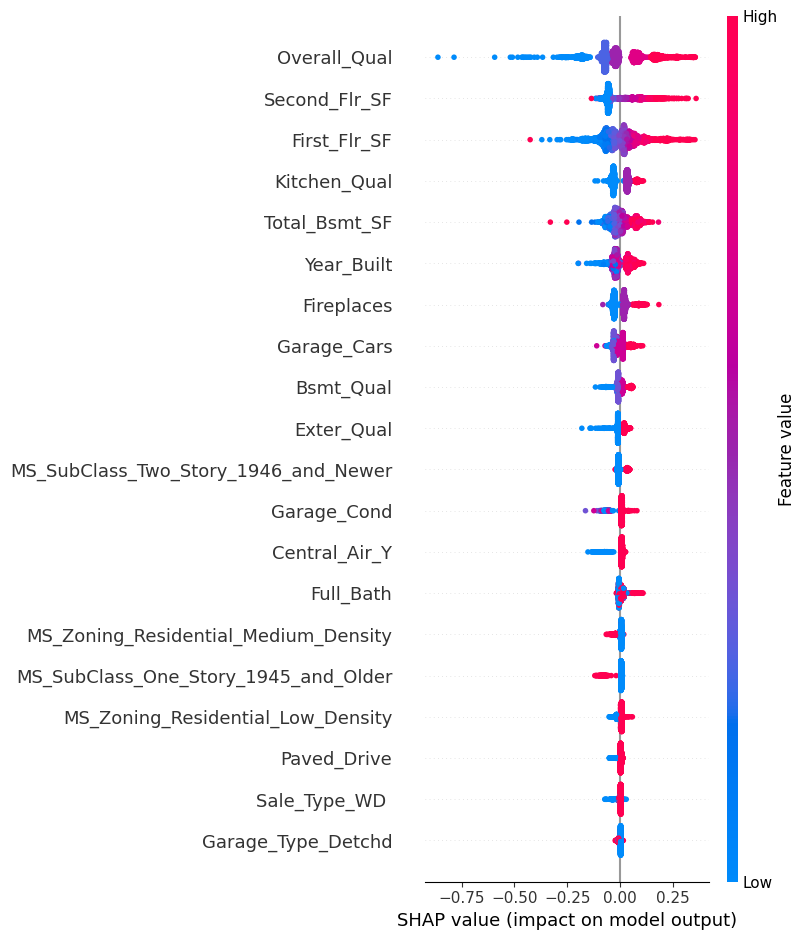

In [99]:
#vemos shap
import shap
XGB_optuna = fitted["XGB_Optuna"]
explainer = shap.Explainer(XGB_optuna  )
shap_values = explainer(X)
shap.summary_plot(shap_values, X)  # resumen de todas las características

In [100]:


for (index, fila), y in zip(df.iterrows(), y_real):
    print(y, fila.Sale_Price, fila.SalePrice * (CPI_TARGET / fila.CPI_sale), fila.Yr_Sold, fila.Mo_Sold, fila.CPI_sale)


AttributeError: 'Series' object has no attribute 'SalePrice'

### Parámetros del modelo

In [101]:
# ----------------------------
# 2) Baseline, límites y costos (FIX)
# ----------------------------
# Requiere que ya existan:
# X, y_real, trained_feats, trained_stats (q05/median/q95), best_linear_model, best_gbr_model

ID_CASA = 987  # índice por fila (iloc)

# 1) Baseline: misma estructura (columnas) que se usó al entrenar
n = len(X)
idx = ID_CASA if 0 <= ID_CASA < n else 0  # fallback si se pasa de rango
baseline = X.iloc[idx].astype(float)

print("Caso base (features):")
print(baseline.to_string())

# 2) Elige el predictor (pipeline) que quieras evaluar como baseline
#    Puedes cambiar a best_linear_model si prefieres la lineal
PREDICTOR = XGB_optuna

# Predicción en log (nuestros modelos entrenan sobre y_log)
pred_log = float(PREDICTOR.predict(baseline.to_frame().T)[0])
precio_base_pred = float(np.expm1(pred_log))
print(f"\nPrecio base predicho: {precio_base_pred:,.0f}")

# Precio real de esa fila (en escala original; ya inflacionado si ajustaste antes)
precio_real = float(y_real.iloc[idx])
print(f"Precio real observado: {precio_real:,.0f}")

# 3) Cuantil 95% por feature (para cotas superiores)
q95 = trained_stats["q95"]  # viene de: trained_stats = DataFrame({q05, median, q95})

# 4) Costos por unidad (revisa unidades: p. ej., Gr_Liv_Area está en ft²)
default_costs = {
    "Gr_Liv_Area":     200,   # USD por ft²
    "Total_Bsmt_SF":    80,   # USD por ft²
    "Garage_Area":      60,   # USD por ft²
    "Garage_Cars":   17000,   # USD por puesto
    "Full_Bath":     25000,   # USD por baño
    "Fireplaces":      6000,  # USD por chimenea
    "Overall_Qual":   20000,  # USD por subir 1 punto (proxy)
    "KitchenQual_ord": 8000,  # USD por subir 1 nivel (TA→Gd→Ex) (ejemplo)
    "GarageFinish_ord":4000,  # USD por subir 1 nivel (Unf→RFn→Fin) (ejemplo)
}

# 5) "Room to grow" máximo (cuánto puedes mover vs baseline, si la norma/lote lo permite)
room = {
    "Gr_Liv_Area":     400.0,
    "Total_Bsmt_SF":   300.0,
    "Garage_Area":     250.0,
    "Garage_Cars":       1.0,   # sube a 2 si el lote lo permite
    "Full_Bath":         1.0,
    "Fireplaces":        1.0,
    "Overall_Qual":      1.0,
    "KitchenQual_ord":   1.0,
    "GarageFinish_ord":  1.0,
}

# 6) Construir cotas y costos por feature (solo para las usadas al entrenar)
bounds, costs = {}, {}
for f in trained_feats:
    base = float(baseline.get(f, X[f].median()))
    ub_by_room = base + room.get(f, 0.0)          # límite por “capacidad de cambio”
    ub_by_p95  = float(q95.get(f, base))          # límite por mercado (evita extrapolación)
    lb = base                                     # no bajamos de lo que ya tiene la casa base
    ub = max(lb, min(ub_by_room, ub_by_p95))      # asegura lb <= ub
    bounds[f] = (lb, ub)
    costs[f]  = float(default_costs.get(f, 0.0))

BUDGET = 200_000  # mismo orden de magnitud que tus costos (USD en este ejemplo)

print("\nLímites por feature (lb, ub):")
for f, (lb, ub) in bounds.items():
    if ub > lb:
        print(f"  {f:>16}: {lb:,.2f} → {ub:,.2f}")
    else:
        print(f"  {f:>16}: {lb:,.2f} (sin margen de aumento por p95/room)")

print("\nCostos unitarios usados:")
for f in trained_feats:
    if costs[f] > 0:
        print(f"  {f:>16}: {costs[f]:,.0f}")


Caso base (features):
Overall_Qual                               6.0
Year_Built                              1977.0
Exter_Qual                                 2.0
Bsmt_Qual                                  4.0
Total_Bsmt_SF                           1567.0
First_Flr_SF                            1567.0
Second_Flr_SF                              0.0
Full_Bath                                  2.0
Kitchen_Qual                               4.0
Fireplaces                                 2.0
Garage_Cars                                2.0
Garage_Cond                                4.0
Paved_Drive                                3.0
MS_SubClass_One_Story_1945_and_Older       0.0
MS_SubClass_Two_Story_1946_and_Newer       0.0
MS_Zoning_Residential_Low_Density          1.0
MS_Zoning_Residential_Medium_Density       0.0
Central_Air_Y                              1.0
Garage_Type_Detchd                         0.0
Sale_Type_VWD                              0.0
Sale_Type_WD                          

### Guroby

In [104]:
# ======== 1️⃣ Configuración general ========
MODEL_NAME     = "XGB_Optuna"
OBJECTIVE_MODE = "profit"     # "price" | "profit" | "roi"
ROI_MIN        = 0.10         # sólo si OBJECTIVE_MODE == "roi"
PWL_K          = 25           # segmentos PWL para log→precio
BUDGET         = 80000        # 💰 presupuesto máximo

predictor = XGB_optuna       # usamos el modelo optimizado

print(f"→ Usando modelo: {MODEL_NAME}")


# ======== 2️⃣ Validaciones básicas ========
assert 'trained_feats' in globals(), "Falta 'trained_feats'."
feat_names_model = list(trained_feats)

for need in ("baseline", "bounds", "costs", "BUDGET"):
    assert need in globals(), f"Falta '{need}' en el entorno."

missing = [c for c in feat_names_model if c not in bounds or c not in costs or c not in baseline.index]
assert not missing, f"Faltan claves en bounds/baseline/costs para: {missing}"


# ======== 3️⃣ Modelo de optimización en Gurobi ========
m = gp.Model(f"ames_optuna_opt")
int_like = {"Garage_Cars","Full_Bath","Fireplaces","Overall_Qual","KitchenQual_ord","GarageFinish_ord"}

# Variables de decisión
x = {}
for c in feat_names_model:
    lb, ub = bounds[c]
    if c in int_like:
        lb_i, ub_i = int(np.floor(lb)), int(np.ceil(ub))
        if ub_i < lb_i: ub_i = lb_i
        x[c] = m.addVar(lb=lb_i, ub=ub_i, vtype=GRB.INTEGER, name=c)
    else:
        x[c] = m.addVar(lb=float(lb), ub=float(ub), vtype=GRB.CONTINUOUS, name=c)

# Restricción de presupuesto
cost_expr = gp.quicksum(costs[c] * (x[c] - float(baseline[c])) for c in feat_names_model)
m.addConstr(cost_expr <= float(BUDGET), name="Budget")

# DF 1xN con las variables del modelo
x_df = pd.DataFrame([[x[c] for c in feat_names_model]], columns=feat_names_model)

# Variable del predictor (log del precio)
y_pred_log = m.addVar(name="y_pred_log")

# 🔗 Vincular el modelo de ML (Optuna/XGB) con Gurobi
add_predictor_constr(
    gp_model=m,
    predictor=predictor,
    input_vars=x_df,
    output_vars=y_pred_log
)


# ======== 4️⃣ Función objetivo ========
if OBJECTIVE_MODE == "price":
    m.setObjective(y_pred_log, GRB.MAXIMIZE)
else:
    ymin, ymax = np.percentile(y_real, [1, 99])
    xs = np.linspace(ymin, ymax, PWL_K).tolist()
    ys = np.expm1(xs).tolist()

    price = m.addVar(name="price")
    m.addGenConstrPWL(y_pred_log, price, xs, ys, name="log_to_price")

    baseline_vec = pd.DataFrame([baseline[feat_names_model].to_dict()], columns=feat_names_model)
    price_before = float(np.expm1(predictor.predict(baseline_vec))[0])

    if OBJECTIVE_MODE == "profit":
        m.setObjective(price - cost_expr, GRB.MAXIMIZE)
    elif OBJECTIVE_MODE == "roi":
        m.addConstr(price - price_before >= ROI_MIN * cost_expr, name="ROImin")
        m.setObjective(price - cost_expr, GRB.MAXIMIZE)
    else:
        raise ValueError("OBJECTIVE_MODE debe ser 'price', 'profit' o 'roi'.")


# ======== 5️⃣ Resolver ========
m.Params.OutputFlag = 1
m.optimize()


# ======== 6️⃣ Reporte de resultados ========
if m.SolCount > 0:
    baseline_vec = pd.DataFrame([baseline[feat_names_model].to_dict()], columns=feat_names_model)
    price_before_rep = float(np.expm1(predictor.predict(baseline_vec))[0])
    price_after_rep  = float(np.expm1(y_pred_log.X)) if OBJECTIVE_MODE == "price" else float(price.X)

    deltas = {c: x[c].X - float(baseline[c]) for c in feat_names_model}
    spent  = float(cost_expr.getValue())
    profit = price_after_rep - price_before_rep - spent
    roi    = (profit / spent) if spent > 0 else float('nan')

    print("\n=== SOLUCIÓN CASA ÓPTIMA ===")
    print(f"Modelo usado   : {MODEL_NAME}")
    print(f"Objetivo       : {OBJECTIVE_MODE}")
    print(f"Precio antes   : {price_before_rep:,.0f}")
    print(f"Precio después : {price_after_rep:,.0f}")
    print(f"Gasto estimado : {spent:,.0f}  (≤ presupuesto {BUDGET:,.0f})")
    print(f"Ganancia       : {profit:,.0f}   |  ROI: {roi:,.2f}\n")

    print("Cambios en variables accionables:")
    for c in feat_names_model:
        if abs(deltas[c]) > 1e-6:
            print(f" - {c:20s}: {x[c].X:10.3f}  (Δ={deltas[c]:+10.3f})")
else:
    print("❌ No se encontró solución factible.")


→ Usando modelo: XGB_Optuna
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 3185 rows, 9262 columns and 11367 nonzeros
Model fingerprint: 0x5565e76e
Model has 2280 simple general constraints
  2279 INDICATOR, 1 PWL
Variable types: 1080 continuous, 8182 integer (8178 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 3e+04]
  Bounds range     [1e+00, 2e+03]
  RHS range        [2e-05, 4e+05]
  PWLCon x range   [1e+01, 1e+01]
  PWLCon y range   [1e+05, 6e+05]
  GenCon rhs range [1e-07, 2e+03]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 1826 rows and 7928 columns
Presolve time: 0.14s
Presolved: 1359 rows, 1334 columns, 4725 nonzeros
Pre